#Image of Brain Stroke Lesion Segementation classified with X-Net and Quaternion Nerual Network


---


@Authors:
*   Alessandro Lambertini
*   Denise Landini

##Import libraries

In [ ]:
import os
from os import listdir
from os.path import isfile, join, isdir

import numpy as np
from   numpy.random import RandomState

import torch
from   torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from   torch.nn.parameter import Parameter
from   torch.nn import Module
from scipy.stats import chi

import math
import sys
import random
import time
import pdb
import pickle

from imageio import imread,imwrite
from skimage.transform import resize
from skimage import img_as_ubyte
from sklearn.model_selection import train_test_split

from IPython.display import HTML, display
import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Definition of some useful functions and class

In [ ]:
def progress(value, max=100): # External function
  return HTML("""
    <progress
        value='{value}'
        max='{max}',
        style='width: 50%'
    >
        {value}
    </progress>
  """.format(value=value, max=max))

In [ ]:
dir = "/content/drive/My Drive/Colab Notebooks/NN/Patients/"
dir_M = "/content/drive/My Drive/Colab Notebooks/NN/Model/"
dir_H = '/content/drive/My Drive/Colab Notebooks/NN/History/'
input_shape = (224, 192)
npad = ((0, 0), (0, 0), (1, 0))

def rgb2gray(rgb): # External function
  gray = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
  return np.repeat(gray[:, :, np.newaxis], 3, axis=2)

def transformImg(path): # External function modified
  img = imread(path)
  img = np.array([img.transpose(),]*3).transpose()
  img = rgb2gray(img)
  img = resize(img, input_shape)
  img = img / 255.

  img = np.pad(img, pad_width=npad, mode='constant', constant_values=0)
  img = np.transpose(img, (2,0,1))
  img = np.reshape(img, (1, img.shape[0], img.shape[1], img.shape[2]))
  return img

In [ ]:
def saveHistory(history, problem):
  filename = os.path.join(dir_H, '%s.hist' %problem)
  with open(filename, 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)
  print("\nHystory saved on file %s" %filename)

def loadHistory(problem):
  filename = os.path.join(dir_H, '%s.hist' %problem)
  try:
    with open(filename, 'rb') as f:
      history = pickle.load(f)
      print("\nHistory loaded successfully from file %s" %filename)
  except OSError:    
    print("\nHistory file %s not found!!!" %filename)
    history = None
  return history

def plt_data_from_history(history, name, data):
  assert data in history.keys()

  plt.plot(history[data])
  plt.plot(history['val_' + data])
  plt.title(name + ' ' + data)
  plt.ylabel(data)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

##Quaternion

###Quaternion utils

In [ ]:
##########################################################
# pytorch-qnn v1.0
# Titouan Parcollet
# LIA, Université d'Avignon et des Pays du Vaucluse
# ORKIS, Aix-en-provence
# October 2018
##########################################################

def q_normalize(input, channel=1):

    r = get_r(input)
    i = get_i(input)
    j = get_j(input)
    k = get_k(input)

    norm = torch.sqrt(r*r + i*i + j*j + k*k + 0.0001)
    r = r / norm
    i = i / norm
    j = j / norm
    k = k / norm

    return torch.cat([r,i,j,k], dim=channel)


def check_input(input):

    if input.dim() not in {2, 3, 4, 5}:
        raise RuntimeError(
            "Quaternion linear accepts only input of dimension 2 or 3. Quaternion conv accepts up to 5 dim "
            " input.dim = " + str(input.dim())
        )

    if input.dim() < 4:
        nb_hidden = input.size()[-1]
    else:
        nb_hidden = input.size()[1]

    if nb_hidden % 4 != 0:
        raise RuntimeError(
            "Quaternion Tensors must be divisible by 4."
            " input.size()[1] = " + str(nb_hidden)
        )
#
# Getters
#
def get_r(input):
    check_input(input)
    if input.dim() < 4:
        nb_hidden = input.size()[-1]
    else:
        nb_hidden = input.size()[1]

    if input.dim() == 2:
        return input.narrow(1, 0, nb_hidden // 4)
    if input.dim() == 3:
        return input.narrow(2, 0, nb_hidden // 4)
    if input.dim() >= 4:
        return input.narrow(1, 0, nb_hidden // 4)


def get_i(input):
    if input.dim() < 4:
        nb_hidden = input.size()[-1]
    else:
        nb_hidden = input.size()[1]
    if input.dim() == 2:
        return input.narrow(1, nb_hidden // 4, nb_hidden // 4)
    if input.dim() == 3:
        return input.narrow(2, nb_hidden // 4, nb_hidden // 4)
    if input.dim() >= 4:
        return input.narrow(1, nb_hidden // 4, nb_hidden // 4)

def get_j(input):
    check_input(input)
    if input.dim() < 4:
        nb_hidden = input.size()[-1]
    else:
        nb_hidden = input.size()[1]
    if input.dim() == 2:
        return input.narrow(1, nb_hidden // 2, nb_hidden // 4)
    if input.dim() == 3:
        return input.narrow(2, nb_hidden // 2, nb_hidden // 4)
    if input.dim() >= 4:
        return input.narrow(1, nb_hidden // 2, nb_hidden // 4)

def get_k(input):
    check_input(input)
    if input.dim() < 4:
        nb_hidden = input.size()[-1]
    else:
        nb_hidden = input.size()[1]
    if input.dim() == 2:
        return input.narrow(1, nb_hidden - nb_hidden // 4, nb_hidden // 4)
    if input.dim() == 3:
        return input.narrow(2, nb_hidden - nb_hidden // 4, nb_hidden // 4)
    if input.dim() >= 4:
        return input.narrow(1, nb_hidden - nb_hidden // 4, nb_hidden // 4)


def get_modulus(input, vector_form=False):
    check_input(input)
    r = get_r(input)
    i = get_i(input)
    j = get_j(input)
    k = get_k(input)
    if vector_form:
        return torch.sqrt(r * r + i * i + j * j + k * k)
    else:
        return torch.sqrt((r * r + i * i + j * j + k * k).sum(dim=0))


def get_normalized(input, eps=0.0001):
    check_input(input)
    data_modulus = get_modulus(input)
    if input.dim() == 2:
        data_modulus_repeated = data_modulus.repeat(1, 4)
    elif input.dim() == 3:
        data_modulus_repeated = data_modulus.repeat(1, 1, 4)
    return input / (data_modulus_repeated.expand_as(input) + eps)


def quaternion_exp(input):

    r      = get_r(input)
    i      = get_i(input)
    j      = get_j(input)
    k      = get_k(input)


    norm_v = torch.sqrt(i*i+j*j+k*k) + 0.0001
    exp    = torch.exp(r)

    r      = torch.cos(norm_v)
    i      = (i / norm_v) * torch.sin(norm_v)
    j      = (j / norm_v) * torch.sin(norm_v)
    k      = (k / norm_v) * torch.sin(norm_v)


    return torch.cat([exp*r, exp*i, exp*j, exp*k], dim=1)


def quaternion_conv(input, r_weight, i_weight, j_weight, k_weight, bias, stride,
                    padding, groups, dilatation):
    """
    Applies a quaternion convolution to the incoming data:
    """

    cat_kernels_4_r = torch.cat([r_weight, -i_weight, -j_weight, -k_weight], dim=1)
    cat_kernels_4_i = torch.cat([i_weight,  r_weight, -k_weight, j_weight], dim=1)
    cat_kernels_4_j = torch.cat([j_weight,  k_weight, r_weight, -i_weight], dim=1)
    cat_kernels_4_k = torch.cat([k_weight,  -j_weight, i_weight, r_weight], dim=1)

    cat_kernels_4_quaternion   = torch.cat([cat_kernels_4_r, cat_kernels_4_i, cat_kernels_4_j, cat_kernels_4_k], dim=0)

    if   input.dim() == 3:
        convfunc = F.conv1d
    elif input.dim() == 4:
        convfunc = F.conv2d
    elif input.dim() == 5:
        convfunc = F.conv3d
    else:
        raise Exception("The convolutional input is either 3, 4 or 5 dimensions."
                        " input.dim = " + str(input.dim()))

    return convfunc(input, cat_kernels_4_quaternion, bias, stride, padding, dilatation, groups)

def quaternion_transpose_conv(input, r_weight, i_weight, j_weight, k_weight, bias, stride,
                    padding, output_padding, groups, dilatation):
    """
    Applies a quaternion trasposed convolution to the incoming data:

    """

    cat_kernels_4_r = torch.cat([r_weight, -i_weight, -j_weight, -k_weight], dim=1)
    cat_kernels_4_i = torch.cat([i_weight,  r_weight, -k_weight, j_weight], dim=1)
    cat_kernels_4_j = torch.cat([j_weight,  k_weight, r_weight, -i_weight], dim=1)
    cat_kernels_4_k = torch.cat([k_weight,  -j_weight, i_weight, r_weight], dim=1)
    cat_kernels_4_quaternion   = torch.cat([cat_kernels_4_r, cat_kernels_4_i, cat_kernels_4_j, cat_kernels_4_k], dim=0)


    if   input.dim() == 3:
        convfunc = F.conv_transpose1d
    elif input.dim() == 4:
        convfunc = F.conv_transpose2d
    elif input.dim() == 5:
        convfunc = F.conv_transpose3d
    else:
        raise Exception("The convolutional input is either 3, 4 or 5 dimensions."
                        " input.dim = " + str(input.dim()))

    return convfunc(input, cat_kernels_4_quaternion, bias, stride, padding, output_padding, groups, dilatation)


def quaternion_conv_rotation(input, zero_kernel, r_weight, i_weight, j_weight, k_weight, bias, stride,
                    padding, groups, dilatation, quaternion_format, scale=None):
    """
    Applies a quaternion rotation and convolution transformation to the incoming data:

    The rotation W*x*W^t can be replaced by R*x following:
    https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation

    Works for unitary and non unitary weights.

    The initial size of the input must be a multiple of 3 if quaternion_format = False and
    4 if quaternion_format = True.
    """

    square_r          = (r_weight*r_weight)
    square_i          = (i_weight*i_weight)
    square_j          = (j_weight*j_weight)
    square_k          = (k_weight*k_weight)

    norm              = torch.sqrt(square_r+square_i+square_j+square_k + 0.0001)

    #print(norm)

    r_n_weight          = (r_weight / norm)
    i_n_weight          = (i_weight / norm)
    j_n_weight          = (j_weight / norm)
    k_n_weight          = (k_weight / norm)

    norm_factor       = 2.0

    square_i          = norm_factor*(i_n_weight*i_n_weight)
    square_j          = norm_factor*(j_n_weight*j_n_weight)
    square_k          = norm_factor*(k_n_weight*k_n_weight)

    ri                = (norm_factor*r_n_weight*i_n_weight)
    rj                = (norm_factor*r_n_weight*j_n_weight)
    rk                = (norm_factor*r_n_weight*k_n_weight)

    ij                = (norm_factor*i_n_weight*j_n_weight)
    ik                = (norm_factor*i_n_weight*k_n_weight)

    jk                = (norm_factor*j_n_weight*k_n_weight)

    if quaternion_format:
        if scale is not None:
            rot_kernel_1  = torch.cat([zero_kernel, scale * (1.0 - (square_j + square_k)), scale *(ij-rk), scale *(ik+rj)], dim=1)
            rot_kernel_2  = torch.cat([zero_kernel, scale *(ij+rk), scale *(1.0 - (square_i + square_k)), scale *(jk-ri)], dim=1)
            rot_kernel_3  = torch.cat([zero_kernel, scale *(ik-rj), scale *(jk+ri), scale *(1.0 - (square_i + square_j))], dim=1)
        else:
            rot_kernel_1  = torch.cat([zero_kernel, (1.0 - (square_j + square_k)), (ij-rk), (ik+rj)], dim=1)
            rot_kernel_2  = torch.cat([zero_kernel, (ij+rk), (1.0 - (square_i + square_k)), (jk-ri)], dim=1)
            rot_kernel_3  = torch.cat([zero_kernel, (ik-rj), (jk+ri), (1.0 - (square_i + square_j))], dim=1)

        zero_kernel2  = torch.cat([zero_kernel, zero_kernel, zero_kernel, zero_kernel], dim=1)
        global_rot_kernel = torch.cat([zero_kernel2, rot_kernel_1, rot_kernel_2, rot_kernel_3], dim=0)

    else:
        if scale is not None:
            rot_kernel_1  = torch.cat([scale * (1.0 - (square_j + square_k)), scale *(ij-rk), scale *(ik+rj)], dim=0)
            rot_kernel_2  = torch.cat([scale *(ij+rk), scale *(1.0 - (square_i + square_k)), scale *(jk-ri)], dim=0)
            rot_kernel_3  = torch.cat([scale *(ik-rj), scale *(jk+ri), scale *(1.0 - (square_i + square_j))], dim=0)
        else:
            rot_kernel_1  = torch.cat([1.0 - (square_j + square_k), (ij-rk), (ik+rj)], dim=0)
            rot_kernel_2  = torch.cat([(ij+rk), 1.0 - (square_i + square_k), (jk-ri)], dim=0)
            rot_kernel_3  = torch.cat([(ik-rj), (jk+ri), (1.0 - (square_i + square_j))], dim=0)

        global_rot_kernel = torch.cat([rot_kernel_1, rot_kernel_2, rot_kernel_3], dim=0)

    #print(input.shape)
    #print(square_r.shape)
    #print(global_rot_kernel.shape)

    if   input.dim() == 3:
        convfunc = F.conv1d
    elif input.dim() == 4:
        convfunc = F.conv2d
    elif input.dim() == 5:
        convfunc = F.conv3d
    else:
        raise Exception("The convolutional input is either 3, 4 or 5 dimensions."
                        " input.dim = " + str(input.dim()))

    return convfunc(input, global_rot_kernel, bias, stride, padding, dilatation, groups)

def quaternion_transpose_conv_rotation(input, zero_kernel, r_weight, i_weight, j_weight, k_weight, bias, stride,
                    padding, output_padding, groups, dilatation, quaternion_format):
    """
    Applies a quaternion rotation and transposed convolution transformation to the incoming data:

    The rotation W*x*W^t can be replaced by R*x following:
    https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation

    Works for unitary and non unitary weights.

    The initial size of the input must be a multiple of 3 if quaternion_format = False and
    4 if quaternion_format = True.

    """

    square_r          = (r_weight*r_weight)
    square_i          = (i_weight*i_weight)
    square_j          = (j_weight*j_weight)
    square_k          = (k_weight*k_weight)

    norm              = torch.sqrt(square_r+square_i+square_j+square_k + 0.0001)

    r_weight          = (r_weight / norm)
    i_weight          = (i_weight / norm)
    j_weight          = (j_weight / norm)
    k_weight          = (k_weight / norm)

    norm_factor       = 2.0

    square_i          = norm_factor*(i_weight*i_weight)
    square_j          = norm_factor*(j_weight*j_weight)
    square_k          = norm_factor*(k_weight*k_weight)

    ri                = (norm_factor*r_weight*i_weight)
    rj                = (norm_factor*r_weight*j_weight)
    rk                = (norm_factor*r_weight*k_weight)

    ij                = (norm_factor*i_weight*j_weight)
    ik                = (norm_factor*i_weight*k_weight)

    jk                = (norm_factor*j_weight*k_weight)

    if quaternion_format:
        rot_kernel_1  = torch.cat([zero_kernel, 1.0 - (square_j + square_k), ij-rk, ik+rj], dim=1)
        rot_kernel_2  = torch.cat([zero_kernel, ij+rk, 1.0 - (square_i + square_k), jk-ri], dim=1)
        rot_kernel_3  = torch.cat([zero_kernel, ik-rj, jk+ri, 1.0 - (square_i + square_j)], dim=1)

        zero_kernel2  = torch.zeros(rot_kernel_1.shape).cuda()
        global_rot_kernel = torch.cat([zero_kernel2, rot_kernel_1, rot_kernel_2, rot_kernel_3], dim=0)
    else:
        rot_kernel_1  = torch.cat([1.0 - (square_j + square_k), ij-rk, ik+rj], dim=1)
        rot_kernel_2  = torch.cat([ij+rk, 1.0 - (square_i + square_k), jk-ri], dim=1)
        rot_kernel_3  = torch.cat([ik-rj, jk+ri, 1.0 - (square_i + square_j)], dim=1)
        global_rot_kernel = torch.cat([rot_kernel_1, rot_kernel_2, rot_kernel_3], dim=0)


    if   input.dim() == 3:
        convfunc = F.conv_transpose1d
    elif input.dim() == 4:
        convfunc = F.conv_transpose2d
    elif input.dim() == 5:
        convfunc = F.conv_transpose3d
    else:
        raise Exception("The convolutional input is either 3, 4 or 5 dimensions."
                        " input.dim = " + str(input.dim()))

    return convfunc(input, cat_kernels_4_quaternion, bias, stride, padding, output_padding, groups, dilatation)


def quaternion_linear(input, r_weight, i_weight, j_weight, k_weight, bias=True):
    """
    Applies a quaternion linear transformation to the incoming data:

    It is important to notice that the forward phase of a QNN is defined
    as W * Inputs (with * equal to the Hamilton product). The constructed
    cat_kernels_4_quaternion is a modified version of the quaternion representation
    so when we do torch.mm(Input,W) it's equivalent to W * Inputs.

    """

    cat_kernels_4_r = torch.cat([r_weight, -i_weight, -j_weight, -k_weight], dim=0)
    cat_kernels_4_i = torch.cat([i_weight,  r_weight, -k_weight, j_weight], dim=0)
    cat_kernels_4_j = torch.cat([j_weight,  k_weight, r_weight, -i_weight], dim=0)
    cat_kernels_4_k = torch.cat([k_weight,  -j_weight, i_weight, r_weight], dim=0)
    cat_kernels_4_quaternion   = torch.cat([cat_kernels_4_r, cat_kernels_4_i, cat_kernels_4_j, cat_kernels_4_k], dim=1)

    if input.dim() == 2 :

        if bias is not None:
            return torch.addmm(bias, input, cat_kernels_4_quaternion)
        else:
            return torch.mm(input, cat_kernels_4_quaternion)
    else:
        output = torch.matmul(input, cat_kernels_4_quaternion)
        if bias is not None:
            return output+bias
        else:
            return output


def quaternion_linear_rotation(input, zero_kernel, r_weight, i_weight, j_weight, k_weight, bias=None,
                               quaternion_format=False, scale=None):
    """
    Applies a quaternion rotation transformation to the incoming data:

    The rotation W*x*W^t can be replaced by R*x following:
    https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation

    Works for unitary and non unitary weights.

    The initial size of the input must be a multiple of 3 if quaternion_format = False and
    4 if quaternion_format = True.
    """

    square_r          = (r_weight*r_weight)
    square_i          = (i_weight*i_weight)
    square_j          = (j_weight*j_weight)
    square_k          = (k_weight*k_weight)

    norm              = torch.sqrt(square_r+square_i+square_j+square_k + 0.0001)

    r_n_weight          = (r_weight / norm)
    i_n_weight          = (i_weight / norm)
    j_n_weight          = (j_weight / norm)
    k_n_weight          = (k_weight / norm)

    norm_factor       = 2.0

    square_i          = norm_factor*(i_n_weight*i_n_weight)
    square_j          = norm_factor*(j_n_weight*j_n_weight)
    square_k          = norm_factor*(k_n_weight*k_n_weight)

    ri                = (norm_factor*r_n_weight*i_n_weight)
    rj                = (norm_factor*r_n_weight*j_n_weight)
    rk                = (norm_factor*r_n_weight*k_n_weight)

    ij                = (norm_factor*i_n_weight*j_n_weight)
    ik                = (norm_factor*i_n_weight*k_n_weight)

    jk                = (norm_factor*j_n_weight*k_n_weight)

    if quaternion_format:
        if scale is not None:
            rot_kernel_1  = torch.cat([zero_kernel, scale * (1.0 - (square_j + square_k)), scale *(ij-rk), scale *(ik+rj)], dim=0)
            rot_kernel_2  = torch.cat([zero_kernel, scale *(ij+rk), scale *(1.0 - (square_i + square_k)), scale *(jk-ri)], dim=0)
            rot_kernel_3  = torch.cat([zero_kernel, scale *(ik-rj), scale *(jk+ri), scale *(1.0 - (square_i + square_j))], dim=0)
        else:
            rot_kernel_1  = torch.cat([zero_kernel, (1.0 - (square_j + square_k)), (ij-rk), (ik+rj)], dim=0)
            rot_kernel_2  = torch.cat([zero_kernel, (ij+rk), (1.0 - (square_i + square_k)), (jk-ri)], dim=0)
            rot_kernel_3  = torch.cat([zero_kernel, (ik-rj), (jk+ri), (1.0 - (square_i + square_j))], dim=0)

        zero_kernel2  = torch.cat([zero_kernel, zero_kernel, zero_kernel, zero_kernel], dim=0)
        global_rot_kernel = torch.cat([zero_kernel2, rot_kernel_1, rot_kernel_2, rot_kernel_3], dim=1)

    else:
        if scale is not None:
            rot_kernel_1  = torch.cat([scale * (1.0 - (square_j + square_k)), scale *(ij-rk), scale *(ik+rj)], dim=0)
            rot_kernel_2  = torch.cat([scale *(ij+rk), scale *(1.0 - (square_i + square_k)), scale *(jk-ri)], dim=0)
            rot_kernel_3  = torch.cat([scale *(ik-rj), scale *(jk+ri), scale *(1.0 - (square_i + square_j))], dim=0)
        else:
            rot_kernel_1  = torch.cat([1.0 - (square_j + square_k), (ij-rk), (ik+rj)], dim=0)
            rot_kernel_2  = torch.cat([(ij+rk), 1.0 - (square_i + square_k), (jk-ri)], dim=0)
            rot_kernel_3  = torch.cat([(ik-rj), (jk+ri), (1.0 - (square_i + square_j))], dim=0)

        global_rot_kernel = torch.cat([rot_kernel_1, rot_kernel_2, rot_kernel_3], dim=1)


    if input.dim() == 2 :
        if bias is not None:
            return torch.addmm(bias, input, global_rot_kernel)
        else:
            return torch.mm(input, global_rot_kernel)
    else:
        output = torch.matmul(input, global_rot_kernel)
        if bias is not None:
            return output+bias
        else:
            return output



# Custom AUTOGRAD for lower VRAM consumption
class QuaternionLinearFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, r_weight, i_weight, j_weight, k_weight, bias=None):
        ctx.save_for_backward(input, r_weight, i_weight, j_weight, k_weight, bias)
        check_input(input)
        cat_kernels_4_r = torch.cat([r_weight, -i_weight, -j_weight, -k_weight], dim=0)
        cat_kernels_4_i = torch.cat([i_weight,  r_weight, -k_weight, j_weight], dim=0)
        cat_kernels_4_j = torch.cat([j_weight,  k_weight, r_weight, -i_weight], dim=0)
        cat_kernels_4_k = torch.cat([k_weight,  -j_weight, i_weight, r_weight], dim=0)
        cat_kernels_4_quaternion = torch.cat([cat_kernels_4_r, cat_kernels_4_i, cat_kernels_4_j, cat_kernels_4_k], dim=1)
        if input.dim() == 2 :
            if bias is not None:
                return torch.addmm(bias, input, cat_kernels_4_quaternion)
            else:
                return torch.mm(input, cat_kernels_4_quaternion)
        else:
            output = torch.matmul(input, cat_kernels_4_quaternion)
            if bias is not None:
                return output+bias
            else:
                return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):

        input, r_weight, i_weight, j_weight, k_weight, bias = ctx.saved_tensors
        grad_input = grad_weight_r = grad_weight_i = grad_weight_j = grad_weight_k = grad_bias = None

        input_r = torch.cat([r_weight, -i_weight, -j_weight, -k_weight], dim=0)
        input_i = torch.cat([i_weight,  r_weight, -k_weight, j_weight], dim=0)
        input_j = torch.cat([j_weight,  k_weight, r_weight, -i_weight], dim=0)
        input_k = torch.cat([k_weight,  -j_weight, i_weight, r_weight], dim=0)
        cat_kernels_4_quaternion_T = Variable(torch.cat([input_r, input_i, input_j, input_k], dim=1).permute(1,0), requires_grad=False)

        r = get_r(input)
        i = get_i(input)
        j = get_j(input)
        k = get_k(input)
        input_r = torch.cat([r, -i, -j, -k], dim=0)
        input_i = torch.cat([i,  r, -k, j], dim=0)
        input_j = torch.cat([j,  k, r, -i], dim=0)
        input_k = torch.cat([k,  -j, i, r], dim=0)
        input_mat = Variable(torch.cat([input_r, input_i, input_j, input_k], dim=1), requires_grad=False)

        r = get_r(grad_output)
        i = get_i(grad_output)
        j = get_j(grad_output)
        k = get_k(grad_output)
        input_r = torch.cat([r, i, j, k], dim=1)
        input_i = torch.cat([-i,  r, k, -j], dim=1)
        input_j = torch.cat([-j,  -k, r, i], dim=1)
        input_k = torch.cat([-k,  j, -i, r], dim=1)
        grad_mat = torch.cat([input_r, input_i, input_j, input_k], dim=0)

        if ctx.needs_input_grad[0]:
            grad_input  = grad_output.mm(cat_kernels_4_quaternion_T)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_mat.permute(1,0).mm(input_mat).permute(1,0)
            unit_size_x = r_weight.size(0)
            unit_size_y = r_weight.size(1)
            grad_weight_r = grad_weight.narrow(0,0,unit_size_x).narrow(1,0,unit_size_y)
            grad_weight_i = grad_weight.narrow(0,0,unit_size_x).narrow(1,unit_size_y,unit_size_y)
            grad_weight_j = grad_weight.narrow(0,0,unit_size_x).narrow(1,unit_size_y*2,unit_size_y)
            grad_weight_k = grad_weight.narrow(0,0,unit_size_x).narrow(1,unit_size_y*3,unit_size_y)
        if ctx.needs_input_grad[5]:
            grad_bias   = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight_r, grad_weight_i, grad_weight_j, grad_weight_k, grad_bias

def hamilton_product(q0, q1):
    """
    Applies a Hamilton product q0 * q1:
    Shape:
        - q0, q1 should be (batch_size, quaternion_number)
        (rr' - xx' - yy' - zz')  +
        (rx' + xr' + yz' - zy')i +
        (ry' - xz' + yr' + zx')j +
        (rz' + xy' - yx' + zr')k +
    """

    q1_r = get_r(q1)
    q1_i = get_i(q1)
    q1_j = get_j(q1)
    q1_k = get_k(q1)

    # rr', xx', yy', and zz'
    r_base = torch.mul(q0, q1)
    # (rr' - xx' - yy' - zz')
    r   = get_r(r_base) - get_i(r_base) - get_j(r_base) - get_k(r_base)

    # rx', xr', yz', and zy'
    i_base = torch.mul(q0, torch.cat([q1_i, q1_r, q1_k, q1_j], dim=1))
    # (rx' + xr' + yz' - zy')
    i   = get_r(i_base) + get_i(i_base) + get_j(i_base) - get_k(i_base)

    # ry', xz', yr', and zx'
    j_base = torch.mul(q0, torch.cat([q1_j, q1_k, q1_r, q1_i], dim=1))
    # (rx' + xr' + yz' - zy')
    j   = get_r(j_base) - get_i(j_base) + get_j(j_base) + get_k(j_base)

    # rz', xy', yx', and zr'
    k_base = torch.mul(q0, torch.cat([q1_k, q1_j, q1_i, q1_r], dim=1))
    # (rx' + xr' + yz' - zy')
    k   = get_r(k_base) + get_i(k_base) - get_j(k_base) + get_k(k_base)

    return torch.cat([r, i, j, k], dim=1)

#
# PARAMETERS INITIALIZATION
#

def unitary_init(in_features, out_features, rng, kernel_size=None, criterion='he'):

    if kernel_size is not None:
        receptive_field = np.prod(kernel_size)
        fan_in          = in_features  * receptive_field
        fan_out         = out_features * receptive_field
    else:
        fan_in          = in_features
        fan_out         = out_features


    if kernel_size is None:
        kernel_shape = (in_features, out_features)
    else:
        if type(kernel_size) is int:
            kernel_shape = (out_features, in_features) + tuple((kernel_size,))
        else:
            kernel_shape = (out_features, in_features) + (*kernel_size,)

    number_of_weights = np.prod(kernel_shape)
    v_r = np.random.uniform(-1.0,1.0,number_of_weights)
    v_i = np.random.uniform(-1.0,1.0,number_of_weights)
    v_j = np.random.uniform(-1.0,1.0,number_of_weights)
    v_k = np.random.uniform(-1.0,1.0,number_of_weights)

    # Unitary quaternion
    for i in range(0, number_of_weights):
        norm = np.sqrt(v_r[i]**2 + v_i[i]**2 + v_j[i]**2 + v_k[i]**2)+0.0001
        v_r[i]/= norm
        v_i[i]/= norm
        v_j[i]/= norm
        v_k[i]/= norm
    v_r = v_r.reshape(kernel_shape)
    v_i = v_i.reshape(kernel_shape)
    v_j = v_j.reshape(kernel_shape)
    v_k = v_k.reshape(kernel_shape)

    return (v_r, v_i, v_j, v_k)

def random_init(in_features, out_features, rng, kernel_size=None, criterion='glorot'):

    if kernel_size is not None:
        receptive_field = np.prod(kernel_size)
        fan_in          = in_features  * receptive_field
        fan_out         = out_features * receptive_field
    else:
        fan_in          = in_features
        fan_out         = out_features

    if criterion == 'glorot':
        s = 1. / np.sqrt(2*(fan_in + fan_out))
    elif criterion == 'he':
        s = 1. / np.sqrt(2*fan_in)
    else:
        raise ValueError('Invalid criterion: ' + criterion)

    if kernel_size is None:
        kernel_shape = (in_features, out_features)
    else:
        if type(kernel_size) is int:
            kernel_shape = (out_features, in_features) + tuple((kernel_size,))
        else:
            kernel_shape = (out_features, in_features) + (*kernel_size,)

    number_of_weights = np.prod(kernel_shape)
    v_r = np.random.uniform(-1.0,1.0,number_of_weights)
    v_i = np.random.uniform(-1.0,1.0,number_of_weights)
    v_j = np.random.uniform(-1.0,1.0,number_of_weights)
    v_k = np.random.uniform(-1.0,1.0,number_of_weights)



    v_r = v_r.reshape(kernel_shape)
    v_i = v_i.reshape(kernel_shape)
    v_j = v_j.reshape(kernel_shape)
    v_k = v_k.reshape(kernel_shape)

    weight_r = v_r
    weight_i = v_i
    weight_j = v_j
    weight_k = v_k
    return (weight_r, weight_i, weight_j, weight_k)


def quaternion_init(in_features, out_features, rng, kernel_size=None, criterion='glorot'):

    if kernel_size is not None:
        receptive_field = np.prod(kernel_size)
        fan_in          = in_features  * receptive_field
        fan_out         = out_features * receptive_field
    else:
        fan_in          = in_features
        fan_out         = out_features

    if criterion == 'glorot':
        s = 1. / np.sqrt(2*(fan_in + fan_out))
    elif criterion == 'he':
        s = 1. / np.sqrt(2*fan_in)
    else:
        raise ValueError('Invalid criterion: ' + criterion)

    rng = RandomState(np.random.randint(1,1234))

    # Generating randoms and purely imaginary quaternions :
    if kernel_size is None:
        kernel_shape = (in_features, out_features)
    else:
        if type(kernel_size) is int:
            kernel_shape = (out_features, in_features) + tuple((kernel_size,))
        else:
            kernel_shape = (out_features, in_features) + (*kernel_size,)

    modulus = chi.rvs(4,loc=0,scale=s,size=kernel_shape)
    number_of_weights = np.prod(kernel_shape)
    v_i = np.random.uniform(-1.0,1.0,number_of_weights)
    v_j = np.random.uniform(-1.0,1.0,number_of_weights)
    v_k = np.random.uniform(-1.0,1.0,number_of_weights)

    # Purely imaginary quaternions unitary
    for i in range(0, number_of_weights):
        norm = np.sqrt(v_i[i]**2 + v_j[i]**2 + v_k[i]**2 +0.0001)
        v_i[i]/= norm
        v_j[i]/= norm
        v_k[i]/= norm
    v_i = v_i.reshape(kernel_shape)
    v_j = v_j.reshape(kernel_shape)
    v_k = v_k.reshape(kernel_shape)

    phase = rng.uniform(low=-np.pi, high=np.pi, size=kernel_shape)

    weight_r = modulus * np.cos(phase)
    weight_i = modulus * v_i*np.sin(phase)
    weight_j = modulus * v_j*np.sin(phase)
    weight_k = modulus * v_k*np.sin(phase)

    return (weight_r, weight_i, weight_j, weight_k)

def create_dropout_mask(dropout_p, size, rng, as_type, operation='linear'):
    if operation == 'linear':
        mask = rng.binomial(n=1, p=1-dropout_p, size=size)
        return Variable(torch.from_numpy(mask).type(as_type))
    else:
         raise Exception("create_dropout_mask accepts only 'linear'. Found operation = "
                        + str(operation))

def affect_init(r_weight, i_weight, j_weight, k_weight, init_func, rng, init_criterion):
    if r_weight.size() != i_weight.size() or r_weight.size() != j_weight.size() or \
    r_weight.size() != k_weight.size() :
         raise ValueError('The real and imaginary weights '
                 'should have the same size . Found: r:'
                 + str(r_weight.size()) +' i:'
                 + str(i_weight.size()) +' j:'
                 + str(j_weight.size()) +' k:'
                 + str(k_weight.size()))

    elif r_weight.dim() != 2:
        raise Exception('affect_init accepts only matrices. Found dimension = '
                        + str(r_weight.dim()))
    kernel_size = None
    r, i, j, k  = init_func(r_weight.size(0), r_weight.size(1), rng, kernel_size, init_criterion)
    r, i, j, k  = torch.from_numpy(r), torch.from_numpy(i), torch.from_numpy(j), torch.from_numpy(k)
    r_weight.data = r.type_as(r_weight.data)
    i_weight.data = i.type_as(i_weight.data)
    j_weight.data = j.type_as(j_weight.data)
    k_weight.data = k.type_as(k_weight.data)


def affect_init_conv(r_weight, i_weight, j_weight, k_weight, kernel_size, init_func, rng,
                     init_criterion):
    if r_weight.size() != i_weight.size() or r_weight.size() != j_weight.size() or \
    r_weight.size() != k_weight.size() :
         raise ValueError('The real and imaginary weights '
                 'should have the same size . Found: r:'
                 + str(r_weight.size()) +' i:'
                 + str(i_weight.size()) +' j:'
                 + str(j_weight.size()) +' k:'
                 + str(k_weight.size()))

    elif 2 >= r_weight.dim():
        raise Exception('affect_conv_init accepts only tensors that have more than 2 dimensions. Found dimension = '
                        + str(real_weight.dim()))

    r, i, j, k = init_func(
        r_weight.size(1),
        r_weight.size(0),
        rng=rng,
        kernel_size=kernel_size,
        criterion=init_criterion
    )
    r, i, j, k = torch.from_numpy(r), torch.from_numpy(i), torch.from_numpy(j), torch.from_numpy(k)
    r_weight.data = r.type_as(r_weight.data)
    i_weight.data = i.type_as(i_weight.data)
    j_weight.data = j.type_as(j_weight.data)
    k_weight.data = k.type_as(k_weight.data)

def get_kernel_and_weight_shape(operation, in_channels, out_channels, kernel_size):
    if operation == 'convolution1d':
        if type(kernel_size) is not int:
            raise ValueError(
                """An invalid kernel_size was supplied for a 1d convolution. The kernel size
                must be integer in the case. Found kernel_size = """ + str(kernel_size)
            )
        else:
            ks = kernel_size
            w_shape = (out_channels, in_channels) + tuple((ks,))
    else:# in case it is 2d or 3d.
        if   operation == 'convolution2d' and type(kernel_size) is int:
            ks = (kernel_size, kernel_size)
        elif operation == 'convolution3d' and type(kernel_size) is int:
            ks = (kernel_size, kernel_size, kernel_size)
        elif type(kernel_size) is not int:
            if   operation == 'convolution2d' and len(kernel_size) != 2:
                raise ValueError(
                    """An invalid kernel_size was supplied for a 2d convolution. The kernel size
                    must be either an integer or a tuple of 2. Found kernel_size = """ + str(kernel_size)
                )
            elif operation == 'convolution3d' and len(kernel_size) != 3:
                raise ValueError(
                    """An invalid kernel_size was supplied for a 3d convolution. The kernel size
                    must be either an integer or a tuple of 3. Found kernel_size = """ + str(kernel_size)
                )
            else:
                ks = kernel_size
        w_shape = (out_channels, in_channels) + (*ks,)
    return ks, w_shape


###Quaternion layers

In [ ]:
##########################################################
# pytorch-qnn v1.0
# Titouan Parcollet
# LIA, Université d'Avignon et des Pays du Vaucluse
# ORKIS, Aix-en-provence
# October 2018
##########################################################

class QuaternionTransposeConv(Module):
    r"""Applies a Quaternion Transposed Convolution (or Deconvolution) to the incoming data.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilatation=1, padding=0, output_padding=0, groups=1, bias=True, init_criterion='he',
                 weight_init='quaternion', seed=None, operation='convolution2d', rotation=False,
                 quaternion_format=False):

        super(QuaternionTransposeConv, self).__init__()

        self.in_channels       = in_channels  // 4
        self.out_channels      = out_channels // 4
        self.stride            = stride
        self.padding           = padding
        self.output_padding    = output_padding
        self.groups            = groups
        self.dilatation        = dilatation
        self.init_criterion    = init_criterion
        self.weight_init       = weight_init
        self.seed              = seed if seed is not None else np.random.randint(0,1234)
        self.rng               = RandomState(self.seed)
        self.operation         = operation
        self.rotation          = rotation
        self.quaternion_format = quaternion_format
        self.winit             = {'quaternion': quaternion_init,
                                  'unitary'   : unitary_init,
                                  'random'    : random_init}[self.weight_init]


        (self.kernel_size, self.w_shape) = get_kernel_and_weight_shape( self.operation,
            self.out_channels, self.in_channels, kernel_size )

        self.r_weight  = Parameter(torch.Tensor(*self.w_shape))
        self.i_weight  = Parameter(torch.Tensor(*self.w_shape))
        self.j_weight  = Parameter(torch.Tensor(*self.w_shape))
        self.k_weight  = Parameter(torch.Tensor(*self.w_shape))


        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        affect_init_conv(self.r_weight, self.i_weight, self.j_weight, self.k_weight,
                    self.kernel_size, self.winit, self.rng, self.init_criterion)
        if self.bias is not None:
           self.bias.data.zero_()

    def forward(self, input):
        if self.rotation:
            return quaternion_tranpose_conv_rotation(input, self.r_weight, self.i_weight,
                self.j_weight, self.k_weight, self.bias, self.stride, self.padding,
                self.output_padding, self.groups, self.dilatation, self.quaternion_format)
        else:
            return quaternion_transpose_conv(input, self.r_weight, self.i_weight, self.j_weight,
                self.k_weight, self.bias, self.stride, self.padding, self.output_padding,
                self.groups, self.dilatation)


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_channels='      + str(self.in_channels) \
            + ', out_channels='   + str(self.out_channels) \
            + ', bias='           + str(self.bias is not None) \
            + ', kernel_size='    + str(self.kernel_size) \
            + ', stride='         + str(self.stride) \
            + ', padding='        + str(self.padding) \
            + ', dilation='       + str(self.dilation) \
            + ', init_criterion=' + str(self.init_criterion) \
            + ', weight_init='    + str(self.weight_init) \
            + ', seed='           + str(self.seed) \
            + ', operation='      + str(self.operation) + ')'

class QuaternionConv(Module):
    r"""Applies a Quaternion Convolution to the incoming data.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilatation=1, padding=0, groups=1, bias=True, init_criterion='glorot',
                 weight_init='quaternion', seed=None, operation='convolution2d', rotation=False, quaternion_format=True, scale=False):

        super(QuaternionConv, self).__init__()

        self.in_channels       = in_channels  // 4
        self.out_channels      = out_channels // 4
        self.stride            = stride
        self.padding           = padding
        self.groups            = groups
        self.dilatation        = dilatation
        self.init_criterion    = init_criterion
        self.weight_init       = weight_init
        self.seed              = seed if seed is not None else np.random.randint(0,1234)
        self.rng               = RandomState(self.seed)
        self.operation         = operation
        self.rotation          = rotation
        self.quaternion_format = quaternion_format
        self.winit             =    {'quaternion': quaternion_init,
                                     'unitary'   : unitary_init,
                                     'random'    : random_init}[self.weight_init]
        self.scale             = scale


        (self.kernel_size, self.w_shape) = get_kernel_and_weight_shape( self.operation,
            self.in_channels, self.out_channels, kernel_size )

        self.r_weight  = Parameter(torch.Tensor(*self.w_shape))
        self.i_weight  = Parameter(torch.Tensor(*self.w_shape))
        self.j_weight  = Parameter(torch.Tensor(*self.w_shape))
        self.k_weight  = Parameter(torch.Tensor(*self.w_shape))

        if self.scale:
            self.scale_param  = Parameter(torch.Tensor(self.r_weight.shape))
        else:
            self.scale_param  = None

        if self.rotation:
            self.zero_kernel = Parameter(torch.zeros(self.r_weight.shape), requires_grad=False)
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        affect_init_conv(self.r_weight, self.i_weight, self.j_weight, self.k_weight,
                    self.kernel_size, self.winit, self.rng, self.init_criterion)
        if self.scale_param is not None:
            torch.nn.init.xavier_uniform_(self.scale_param.data)
        if self.bias is not None:
           self.bias.data.zero_()

    def forward(self, input):
        if self.rotation:
            return quaternion_conv_rotation(input, self.zero_kernel, self.r_weight, self.i_weight, self.j_weight,
                self.k_weight, self.bias, self.stride, self.padding, self.groups, self.dilatation,
                self.quaternion_format, self.scale_param)
        else:
            return quaternion_conv(input, self.r_weight, self.i_weight, self.j_weight,
                self.k_weight, self.bias, self.stride, self.padding, self.groups, self.dilatation)


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_channels='      + str(self.in_channels) \
            + ', out_channels='   + str(self.out_channels) \
            + ', bias='           + str(self.bias is not None) \
            + ', kernel_size='    + str(self.kernel_size) \
            + ', stride='         + str(self.stride) \
            + ', padding='        + str(self.padding) \
            + ', init_criterion=' + str(self.init_criterion) \
            + ', weight_init='    + str(self.weight_init) \
            + ', seed='           + str(self.seed) \
            + ', rotation='       + str(self.rotation) \
            + ', q_format='       + str(self.quaternion_format) \
            + ', operation='      + str(self.operation) + ')'

###Depthwise Separable Convolution

In [ ]:
class DSC_E(nn.Module):
  def __init__(self, nin, nout):
    super(DSC_E, self).__init__()
    self.depthwise = QuaternionConv(nin, nin, kernel_size=3, stride=1, padding=1, groups=1)
    self.pointwise = QuaternionConv(nin, nout, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    debug = False
    if debug:
      print("x.shape : ", x.shape)

    out = self.depthwise(x)
    if debug:
      print("out.shape : ", out.shape)
    out = self.pointwise(out)
    if debug:
      print("out.shape : ", out.shape)

    return out

In [ ]:
class DSC_D(nn.Module):
  def __init__(self, nin, nout):
    super(DSC_D, self).__init__()
    self.depthwise = QuaternionTransposeConv(nin, nin, kernel_size=3, stride=1, padding=1, groups=1)
    self.pointwise = QuaternionTransposeConv(nin, nout, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    debug = False
    if debug:
      print("x.shape : ", x.shape)

    out = self.depthwise(x)
    if debug:
      print("out.shape : ", out.shape)
    out = self.pointwise(out)
    if debug:
      print("out.shape : ", out.shape)

    return out

###Lambda layer

External code

In [ ]:
class LambdaLayer(nn.Module):
  def __init__(self, lambd):
    super(LambdaLayer, self).__init__()
    self.lambd = lambd
  def forward(self, x):
    return self.lambd(x)

##X Net

###X Block E

In [ ]:
class X_Block_E(nn.Module):
  def __init__(self, nin, nout):
    super(X_Block_E, self).__init__()

    self.act = nn.ReLU()

    # Upper block
    self.b1_1 = QuaternionConv(nin, nout, kernel_size=1, stride=1, padding=0)
    self.b1_2 = torch.nn.BatchNorm2d(nout)

    # Bottom layer
    # first DSC
    self.b2_1 = DSC_E(nin, nin)
    self.b2_2 = torch.nn.BatchNorm2d(nin)
    self.b2_3 = QuaternionConv(nin, nout, kernel_size=3, stride=1, padding=1)
    self.b2_4 = torch.nn.BatchNorm2d(nout)

    # second DSC
    self.b2_5 = DSC_E(nout, nout)
    self.b2_6 = torch.nn.BatchNorm2d(nout)
    self.b2_7 = QuaternionConv(nout, nout, kernel_size=3, stride=1, padding=1)
    self.b2_8 = torch.nn.BatchNorm2d(nout)

    # third DSC
    self.b2_9 = DSC_E(nout, nout)
    self.b2_10 = torch.nn.BatchNorm2d(nout)
    self.b2_11 = QuaternionConv(nout, nout, kernel_size=3, stride=1, padding=1)
    self.b2_12 = torch.nn.BatchNorm2d(nout)

  def forward(self, x):
    debug = False
    if debug:
      print("x.shape : ", x.shape)

    # Upper block
    b1_1 = self.act(self.b1_1(x))
    if debug:
      print("b1_1.shape : ", b1_1.shape)
    b1_2 = self.b1_2(b1_1)
    if debug:
      print("b1_2.shape : ", b1_2.shape)

    # Bottom layer
    # first DSC
    b2_1 = self.act(self.b2_1(x))
    if debug:
      print("b2_1.shape : ", b2_1.shape)
    b2_2 = self.b2_2(b2_1)
    if debug:
      print("b2_2.shape : ", b2_2.shape)
    b2_3 = self.act(self.b2_3(b2_2))
    if debug:
      print("b2_3.shape : ", b2_3.shape)
    b2_4 = self.b2_4(b2_3)
    if debug:
      print("b2_4.shape : ", b2_4.shape)
    
    # second DSC
    b2_5 = self.act(self.b2_5(b2_4))
    if debug:
      print("b2_5.shape : ", b2_5.shape)
    b2_6 = self.b2_6(b2_5)
    if debug:
      print("b2_6.shape : ", b2_6.shape)
    b2_7 = self.act(self.b2_7(b2_6))
    if debug:
      print("b2_7.shape : ", b2_7.shape)
    b2_8 = self.b2_4(b2_7)
    if debug:
      print("b2_8.shape : ", b2_8.shape)
    
    # third DSC
    b2_9 = self.act(self.b2_9(b2_8))
    if debug:
      print("b2_9.shape : ", b2_9.shape)
    b2_10 = self.b2_10(b2_9)
    if debug:
      print("b2_10.shape : ", b2_10.shape)
    b2_11 = self.act(self.b2_11(b2_10))
    if debug:
      print("b2_11.shape : ", b2_11.shape)
    b2_12 = self.b2_12(b2_11)
    if debug:
      print("b2_12.shape : ", b2_12.shape)

    out = torch.add(b1_2, b2_12)
    if debug:
      print("out.shape : ", out.shape)

    return out

###FSM

In [ ]:
class FSM(nn.Module):
  def __init__(self):
    super(FSM, self).__init__()

    self.act        = nn.ReLU()

    C = 1024
    Co = int(C // 8)
    
    self.b1_1 = QuaternionConv(C, Co, kernel_size=3, stride=1, padding=1)
    self.b1_2 = torch.nn.BatchNorm2d(Co)

    self.dim1, self.dim2, channels = 14, 12, 128
    Ch = (channels // 2)
    if Ch < 1:
      Ch = 1
    self.Ch = Ch

    self.b2 = QuaternionConv(Co, Ch, kernel_size=1, stride=1, padding=0)
    self.b3 = QuaternionConv(Co, Ch, kernel_size=1, stride=1, padding=0)
    self.b4 = QuaternionConv(Co, Ch, kernel_size=1, stride=1, padding=0)

    self.b6 = QuaternionTransposeConv(Ch, channels, kernel_size=1, stride=1, padding=0)

    self.b7_1 = QuaternionTransposeConv(channels, C, kernel_size=3, stride=1, padding=1)
    self.b7_2 = torch.nn.BatchNorm2d(C)


  def forward(self, x):
    debug = False
    if debug:
      print("x.shape : ", x.shape)

    b1_1 = self.act(self.b1_1(x))
    if debug:
      print("b1_1.shape : ", b1_1.shape)
    b1_2 = self.b1_2(b1_1)
    if debug:
      print("b1_2.shape : ", b1_2.shape)
    
    b2 = self.act(self.b2(b1_2))
    if debug:
      print("b2.shape : ", b2.shape)
    b2 = torch.reshape(b2, (self.Ch, -1, 1, 1))
    if debug:
      print("b2.shape : ", b2.shape)
    b3 = self.act(self.b3(b1_2))
    if debug:
      print("b3.shape : ", b3.shape)
    b3 = torch.reshape(b3, (self.Ch, -1, 1, 1))
    if debug:
      print("b3.shape : ", b3.shape)
    b4 = self.act(self.b4(b1_2))
    if debug:
      print("b4.shape : ", b4.shape)
    b4 = torch.reshape(b4, (self.Ch, -1, 1, 1))
    if debug:
      print("b4.shape : ", b4.shape)
    
    b5 = b2@b3 # dot
    if debug:
      print("b5.shape : ", b5.shape)
    b5_size = b5.shape
    Lambda = LambdaLayer(lambda z: (1. / float(b5_size[-1])) * z)
    b5 = Lambda(b5)
    if debug:
      print("b5.shape : ", b5.shape)

    b6 = b5@b4 # dot
    if debug:
      print("b6.shape : ", b6.shape)
    b6 = torch.reshape(b6, (1, self.Ch, self.dim1, self.dim2))
    if debug:
      print("b6.shape : ", b6.shape)
    b6 = self.act(self.b6(b6))
    if debug:
      print("b6.shape : ", b6.shape)
    b6 = torch.add(b1_2, b6)
    if debug:
      print("b6.shape : ", b6.shape)
    
    b7_1 = self.act(self.b7_1(b6))
    if debug:
      print("b7_1.shape : ", b7_1.shape)
    b7_2 = self.b7_2(b7_1)
    if debug:
      print("b7_2.shape : ", b7_2.shape)
    out = torch.add(b7_2, x)
    if debug:
      print("out.shape : ", out.shape)
    
    return out

###X Block D

In [ ]:
class X_Block_D(nn.Module):
  def __init__(self, nin, nout):
    super(X_Block_D, self).__init__()

    self.act        = nn.ReLU()

    # Upper block
    self.b1_1 = QuaternionTransposeConv(nin, nout, kernel_size=1, stride=1, padding=0)
    self.b1_2 = torch.nn.BatchNorm2d(nout)

    # Bottom layer
    # first DSC
    self.b2_1 = DSC_D(nin, nin)
    self.b2_2 = torch.nn.BatchNorm2d(nin)
    self.b2_3 = QuaternionTransposeConv(nin, nout, kernel_size=3, stride=1, padding=1)
    self.b2_4 = torch.nn.BatchNorm2d(nout)

    # second DSC
    self.b2_5 = DSC_D(nout, nout)
    self.b2_6 = torch.nn.BatchNorm2d(nout)
    self.b2_7 = QuaternionTransposeConv(nout, nout, kernel_size=3, stride=1, padding=1)
    self.b2_8 = torch.nn.BatchNorm2d(nout)

    # third DSC
    self.b2_9 = DSC_D(nout, nout)
    self.b2_10 = torch.nn.BatchNorm2d(nout)
    self.b2_11 = QuaternionTransposeConv(nout, nout, kernel_size=3, stride=1, padding=1)
    self.b2_12 = torch.nn.BatchNorm2d(nout)

  def forward(self, x):
    debug = False
    if debug:
      print("x.shape : ", x.shape)

    # Upper block
    b1_1 = self.act(self.b1_1(x))
    if debug:
      print("b1_1.shape : ", b1_1.shape)
    b1_2 = self.b1_2(b1_1)
    if debug:
      print("b1_2.shape : ", b1_2.shape)

    # Bottom layer
    # first DSC
    b2_1 = self.act(self.b2_1(x))
    if debug:
      print("b2_1.shape : ", b2_1.shape)
    b2_2 = self.b2_2(b2_1)
    if debug:
      print("b2_2.shape : ", b2_2.shape)
    b2_3 = self.act(self.b2_3(b2_2))
    if debug:
      print("b2_3.shape : ", b2_3.shape)
    b2_4 = self.b2_4(b2_3)
    if debug:
      print("b2_4.shape : ", b2_4.shape)
    
    # second DSC
    b2_5 = self.act(self.b2_5(b2_4))
    if debug:
      print("b2_5.shape : ", b2_5.shape)
    b2_6 = self.b2_6(b2_5)
    if debug:
      print("b2_6.shape : ", b2_6.shape)
    b2_7 = self.act(self.b2_7(b2_6))
    if debug:
      print("b2_7.shape : ", b2_7.shape)
    b2_8 = self.b2_4(b2_7)
    if debug:
      print("b2_8.shape : ", b2_8.shape)
    
    # third DSC
    b2_9 = self.act(self.b2_9(b2_8))
    if debug:
      print("b2_9.shape : ", b2_9.shape)
    b2_10 = self.b2_10(b2_9)
    if debug:
      print("b2_10.shape : ", b2_10.shape)
    b2_11 = self.act(self.b2_11(b2_10))
    if debug:
      print("b2_11.shape : ", b2_11.shape)
    b2_12 = self.b2_12(b2_11)
    if debug:
      print("b2_12.shape : ", b2_12.shape)

    out = torch.add(b1_2, b2_12)
    if debug:
      print("out.shape : ", out.shape)

    return out

### Dice and loss functions

In [ ]:
def dice(y_true, y_pred):
  # overlap area
  intersection = torch.sum(y_true * y_pred)

  # total number
  union = torch.sum(y_true) + torch.sum(y_pred)

  if union != 0:
    return 2.0 * intersection / union
  return 0.

def loss_function(y_true, y_pred):
  # binary cross entropy
  error1 = nn.BCELoss()(y_true, y_pred)

  # dice loss
  error2 = 1 - dice(y_true, y_pred)

  return error1 + error2

###Quaternion X-Net

In [ ]:
class Q_X_Net(nn.Module):
  def __init__(self):
    super(Q_X_Net, self).__init__()

    self.act        = nn.ReLU()
    self.output_act = nn.Sigmoid()

    # Encoder
    # first layer
    self.e1_1 = X_Block_E(4, 64)
    self.e1_2 = torch.nn.MaxPool2d(kernel_size=(2, 2))

    # second layer
    self.e2_1 = X_Block_E(64, 128)
    self.e2_2 = torch.nn.MaxPool2d(kernel_size=(2, 2))

    # third layer
    self.e3_1 = X_Block_E(128, 256)
    self.e3_2 = torch.nn.MaxPool2d(kernel_size=(2, 2))

    # fourth layer
    self.e4_1 = X_Block_E(256, 512)
    self.e4_2 = torch.nn.MaxPool2d(kernel_size=(2, 2))

    # fifth layer
    self.encoder_output = X_Block_E(512, 1024)
    # END Encoder

    # FSM
    self.decoder_input = FSM()

    # Decoder
    # first layer
    self.d1_1 = torch.nn.Upsample(scale_factor=2)
    self.d1_2 = QuaternionTransposeConv(1024, 512, kernel_size=3, stride=1, padding=1)
    self.d1_3 = torch.nn.BatchNorm2d(512)
    self.d1_4 = X_Block_D(1024, 512)

    # second layer
    self.d2_1 = torch.nn.Upsample(scale_factor=2)
    self.d2_2 = QuaternionTransposeConv(512, 256, kernel_size=3, stride=1, padding=1)
    self.d2_3 = torch.nn.BatchNorm2d(256)
    self.d2_4 = X_Block_D(512, 256)

    # third layer
    self.d3_1 = torch.nn.Upsample(scale_factor=2)
    self.d3_2 = QuaternionTransposeConv(256, 128, kernel_size=3, stride=1, padding=1)
    self.d3_3 = torch.nn.BatchNorm2d(128)
    self.d3_4 = X_Block_D(256, 128)

    # fourth layer
    self.d4_1 = torch.nn.Upsample(scale_factor=2)
    self.d4_2 = QuaternionTransposeConv(128, 64, kernel_size=3, stride=1, padding=1)
    self.d4_3 = torch.nn.BatchNorm2d(64)
    self.d4_4 = X_Block_D(128, 64)

    # output
    self.decoder_output = QuaternionTransposeConv(64, 4, kernel_size=1, stride=1, padding=0)


  def forward(self, x):
    debug = False
    if debug:
      print("x.shape : ", x.shape)

    # Encoder
    # first layer
    e1_1 = self.act(self.e1_1(x))
    if debug:
      print("e1_1.shape : ", e1_1.shape)
    e1_2 = self.e1_2(e1_1)
    if debug:
      print("e1_2.shape : ", e1_2.shape)

    # second layer
    e2_1 = self.act(self.e2_1(e1_2))
    if debug:
      print("e2_1.shape : ", e2_1.shape)
    e2_2 = self.e2_2(e2_1)
    if debug:
      print("e2_2.shape : ", e2_2.shape)

    # third layer
    e3_1 = self.act(self.e3_1(e2_2))
    if debug:
      print("e3_1.shape : ", e3_1.shape)
    e3_2 = self.e3_2(e3_1)
    if debug:
      print("e3_2.shape : ", e3_2.shape)

    # fourth layer
    e4_1 = self.act(self.e4_1(e3_2))
    if debug:
      print("e4_1.shape : ", e4_1.shape)
    e4_2 = self.e4_2(e4_1)
    if debug:
      print("e4_2.shape : ", e4_2.shape)

    # fifth layer
    encoder_output = self.encoder_output(e4_2)
    if debug:
      print("encoder_output.shape : ", encoder_output.shape)
    # END Encoder

    # FSM
    decoder_input = self.decoder_input(encoder_output)
    if debug:
      print("decoder_input.shape : ", decoder_input.shape)

    # Decoder
    # first layer
    d1_1 = self.d1_1(decoder_input) # e4_2)
    if debug:
      print("d1_1.shape : ", d1_1.shape)
    d1_2 = self.act(self.d1_2(d1_1))
    if debug:
      print("d1_2.shape : ", d1_2.shape)
    d1_3 = self.d1_3(d1_2)
    if debug:
      print("d1_3.shape : ", d1_3.shape)
    d1_3 = torch.cat((e4_1, d1_3), 1)
    if debug:
      print("d1_3.shape : ", d1_3.shape)
    d1_4 = self.d1_4(d1_3)
    if debug:
      print("d1_4.shape : ", d1_4.shape)

    # second layer
    d2_1 = self.d2_1(d1_4)
    if debug:
      print("d2_1.shape : ", d2_1.shape)
    d2_2 = self.act(self.d2_2(d2_1))
    if debug:
      print("d2_2.shape : ", d2_2.shape)
    d2_3 = self.d2_3(d2_2)
    if debug:
      print("d2_3.shape : ", d2_3.shape)
    d2_3 = torch.cat((e3_1, d2_3), 1)
    if debug:
      print("d2_3.shape : ", d2_3.shape)
    d2_4 = self.d2_4(d2_3)
    if debug:
      print("d2_4.shape : ", d2_4.shape)

    # third layer
    d3_1 = self.d3_1(d2_4)
    if debug:
      print("d3_1.shape : ", d3_1.shape)
    d3_2 = self.act(self.d3_2(d3_1))
    if debug:
      print("d3_2.shape : ", d3_2.shape)
    d3_3 = self.d3_3(d3_2)
    if debug:
      print("d3_3.shape : ", d3_3.shape)
    d3_3 = torch.cat((e2_1, d3_3), 1)
    if debug:
      print("d3_3.shape : ", d3_3.shape)
    d3_4 = self.d3_4(d3_3)
    if debug:
      print("d3_4.shape : ", d3_4.shape)

    # fourth layer
    d4_1 = self.d4_1(d3_4) # e1_2) # d3_4)
    if debug:
      print("d4_1.shape : ", d4_1.shape)
    d4_2 = self.act(self.d4_2(d4_1))
    if debug:
      print("d4_2.shape : ", d4_2.shape)
    d4_3 = self.d4_3(d4_2)
    if debug:
      print("d4_3.shape : ", d4_3.shape)
    d4_3 = torch.cat((e1_1, d4_3), 1)
    if debug:
      print("d4_3.shape : ", d4_3.shape)
    d4_4 = self.d4_4(d4_3)
    if debug:
      print("d4_4.shape : ", d4_4.shape)
    
    # output
    decoder_output = self.output_act(self.decoder_output(d4_4))
    if debug:
      print("decoder_output.shape : ", decoder_output.shape)

    return decoder_output

##Load Data

In [ ]:
l_pat = listdir(dir)
l_pat.sort()

images_i = []
images_o = []

num_pat = len(l_pat)

out = display(progress(0, num_pat-1), display_id=True)
print("Image input: %s" %str(input_shape))
print("Patients in the dataset:", num_pat)

for j in range(num_pat):
  patient = l_pat[j]
  if not isdir(dir+patient):
    continue
  path = dir+patient+'/brain/'
  l = sorted(listdir(path))
  l = sorted(l, key = lambda x: int(x[0]) if len(x) < 6 or (len(x) < 14 and x.count("_HGE_Seg")==1) else int(x[:2]) )

  i = 0
  dim = len(l)
  app_i = []
  app_o = []
  while i < dim and l[i].count("20.jpg") == 0: #limited to 19 images to have all the patients with the same number of the images
    app_i.append(transformImg(path+l[i]))
    if i+1 < dim and l[i+1].count("_HGE_Seg")==1:
      i+=1
      app_o.append(transformImg(path+l[i]))
    else:
      app_o.append(transformImg(dir_M+"black.jpg"))
    i+=1
  images_i.append(app_i)
  images_o.append(app_o)
  out.update(progress(j, num_pat-1))

images_i = np.array(images_i)
images_o = np.array(images_o)

Image input: (224, 192)
Patients in the dataset: 82


##Split data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images_i, images_o, test_size=0.2, shuffle= True)

x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
x_test = torch.from_numpy(x_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)
print("x_train.shape : ", x_train.shape)
print("y_train.shape : ", y_train.shape)
print("x_test.shape : ", x_test.shape)
print("y_test.shape : ", y_test.shape)

x_train.shape :  torch.Size([65, 19, 1, 4, 224, 192])
y_train.shape :  torch.Size([65, 19, 1, 4, 224, 192])
x_test.shape :  torch.Size([17, 19, 1, 4, 224, 192])
y_test.shape :  torch.Size([17, 19, 1, 4, 224, 192])


##Train the model

In [ ]:
print("building Quaternion X Net")
net  = Q_X_Net().to(device)

criterion = loss_function# lambda x, y: (1-dice(x, y)) # loss_function
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

nb_param = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("\nQuaternion X Net Build")
print("Model Info --------------------")
print("Number of trainable parameters : "+str(nb_param))

In [ ]:
NUM_EPOCHS = 100
img_out = 0

j_pat = random.randint(0, len(x_test)-1)
j_img = random.randint(0, len(x_test[j_pat])-1)

test_img = x_test[j_pat][j_img]
test_img = test_img.cpu().data.numpy()
test_img = np.transpose(test_img, (0,2,3,1))[:,:,:,1:]
test_img = np.reshape(test_img, (test_img.shape[1], test_img.shape[2], test_img.shape[3]))
imwrite(dir_M+"/save_image_x_test.png", img_as_ubyte(test_img))

loss_train = []
dice_train = []
loss_test = []
dice_test = []

for epoch in range(NUM_EPOCHS):
  print("TRAINING")
  app_loss_train = []
  app_dice_train = []
  app_loss_test = []
  app_dice_test = []
  out_disp = display(progress(0, len(x_train)-1), display_id=True)
  start_pat = time.time()
  for i_pat in range(len(x_train)):

    out_disp.update(progress(i_pat, len(x_train)-1))
    for i_img in range(len(x_train[i_pat])):
      output = net(x_train[i_pat][i_img])
      loss = criterion(output, y_train[i_pat][i_img])
      app_loss_train.append(loss.cpu().item())
      app_dice_train.append(dice(output, y_train[i_pat][i_img]).item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  
  print("TESTING")
  out_disp = display(progress(0, len(x_test)-1), display_id=True)
  for i_pat in range(len(x_test)):
    out_disp.update(progress(i_pat, len(x_test)-1))
    for i_img in range(len(x_test[i_pat])):
      output = net(x_test[i_pat][i_img])
      loss = criterion(output, y_test[i_pat][i_img])
      app_loss_test.append(loss.cpu().item())
      app_dice_test.append(dice(output, y_test[i_pat][i_img]).item())

  
  loss_train.append(sum(app_loss_train)/len(app_loss_train))
  dice_train.append(sum(app_dice_train)/len(app_dice_train))
  loss_test.append(sum(app_loss_test)/len(app_loss_test))
  dice_test.append(sum(app_dice_test)/len(app_dice_test))
  print("epoch ",epoch+1,
        ", dice_train ",dice_train[-1],", loss_train ",loss_train[-1],
        ", dice_test ",dice_test[-1],", loss_test ",loss_test[-1],
        " ,time ", round(time.time() - start_pat, 2), " s\n")
  
  output = net(x_test[j_pat][j_img])
  out = output.cpu().data.numpy()
  out = np.transpose(out, (0,2,3,1))[:,:,:,1:]
  out = np.reshape(out, (out.shape[1], out.shape[2], out.shape[3]))
  imwrite(dir_M+"/save_image"+str(epoch)+".png", img_as_ubyte(out))
  img_out = out

##Save and load Model

In [ ]:
history = {"dice": dice_train, "val_dice": dice_test, "loss": loss_train, "val_loss": loss_test}

problemname = "modelQ_82_0_100"#input("model name: ")
saveHistory(history, problemname)
torch.save(net, dir_M+problemname)

In [ ]:
problemname = input("model name: ")

net = torch.load(dir_M+problemname)
history = loadHistory(problemname)

model name: modelQ_82_0_50_dice

History loaded successfully from file /content/drive/My Drive/Colab Notebooks/NN/History/modelQ_82_0_50_dice.hist


##Evaluation of the model

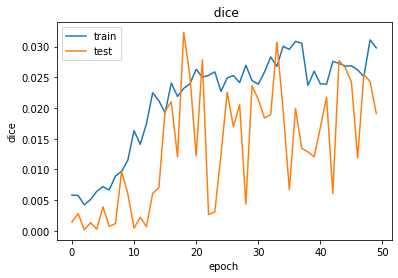

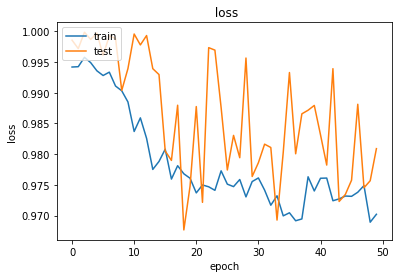

In [ ]:
plt_data_from_history(history, "", 'dice')
plt_data_from_history(history, "", 'loss')


----- Image: 0 -----
Input:


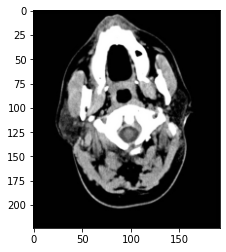

True output:


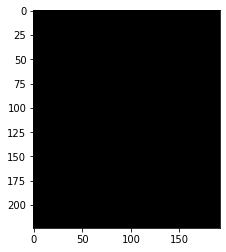

Our output:


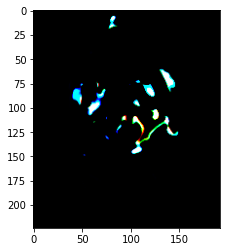


----- Image: 1 -----
Input:


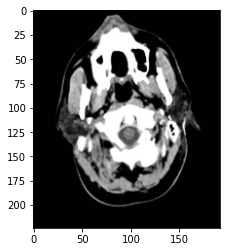

True output:


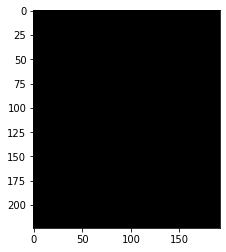

Our output:


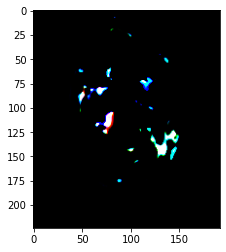


----- Image: 2 -----
Input:


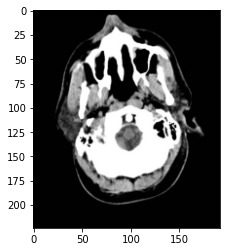

True output:


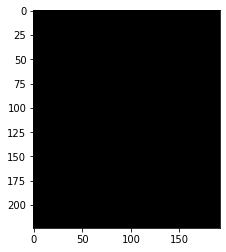

Our output:


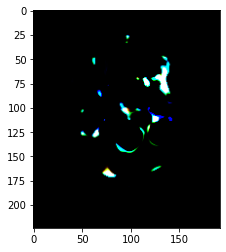


----- Image: 3 -----
Input:


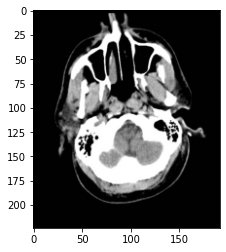

True output:


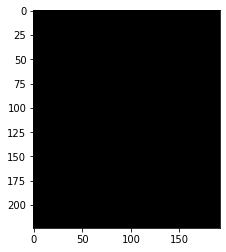

Our output:


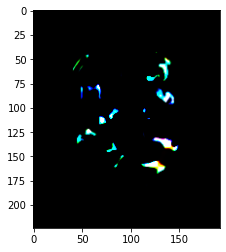


----- Image: 4 -----
Input:


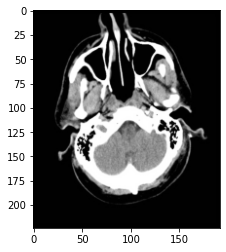

True output:


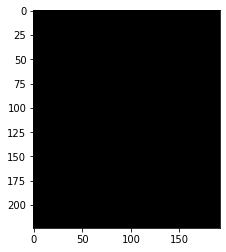

Our output:


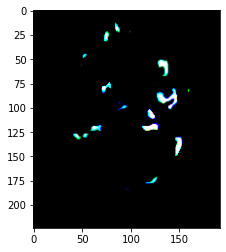


----- Image: 5 -----
Input:


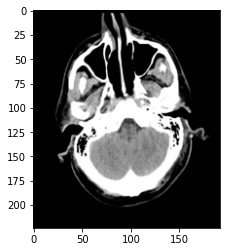

True output:


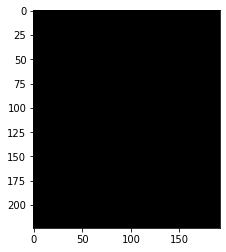

Our output:


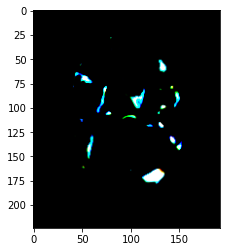


----- Image: 6 -----
Input:


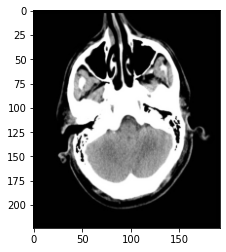

True output:


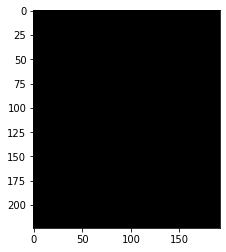

Our output:


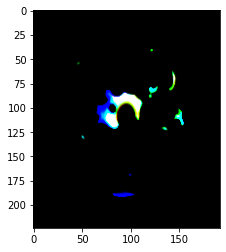


----- Image: 7 -----
Input:


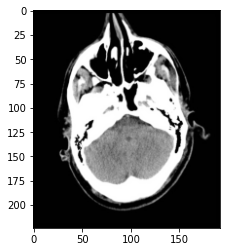

True output:


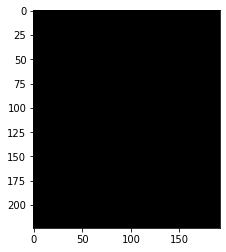

Our output:


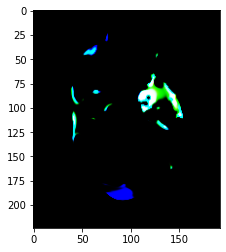


----- Image: 8 -----
Input:


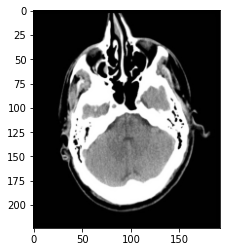

True output:


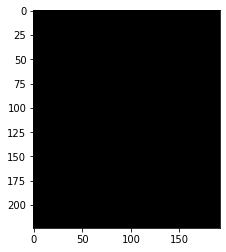

Our output:


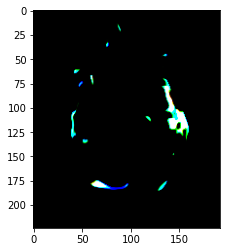


----- Image: 9 -----
Input:


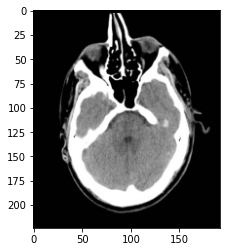

True output:


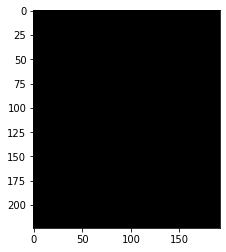

Our output:


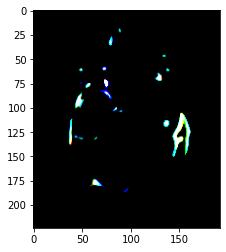


----- Image: 10 -----
Input:


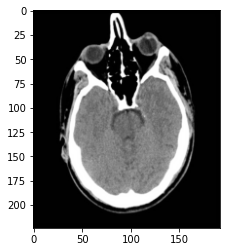

True output:


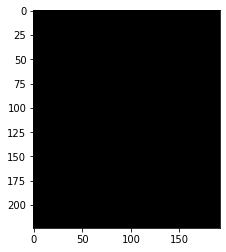

Our output:


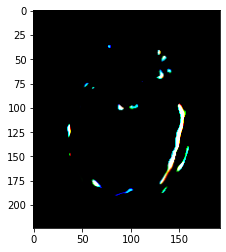


----- Image: 11 -----
Input:


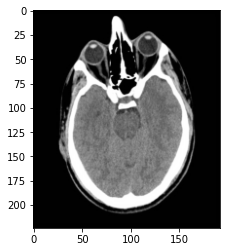

True output:


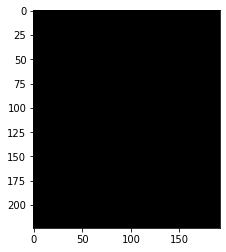

Our output:


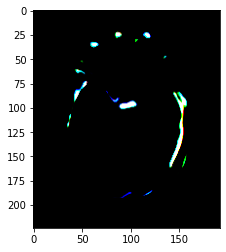


----- Image: 12 -----
Input:


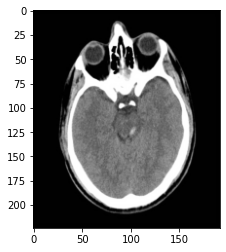

True output:


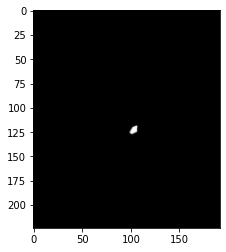

Our output:


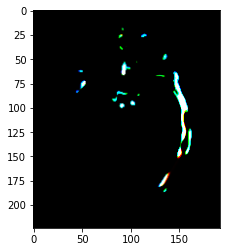


----- Image: 13 -----
Input:


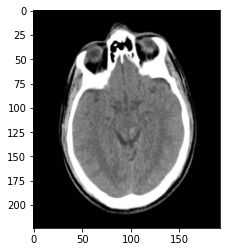

True output:


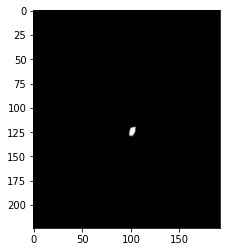

Our output:


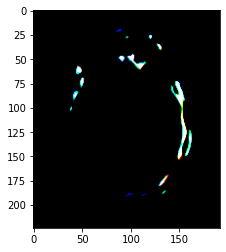


----- Image: 14 -----
Input:


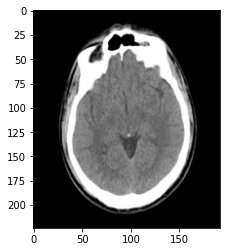

True output:


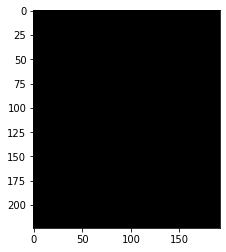

Our output:


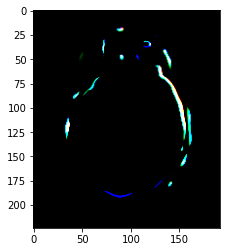


----- Image: 15 -----
Input:


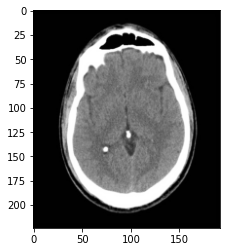

True output:


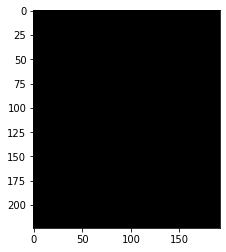

Our output:


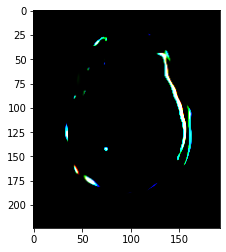


----- Image: 16 -----
Input:


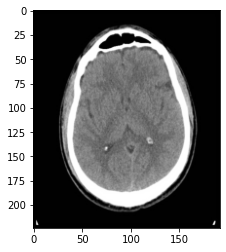

True output:


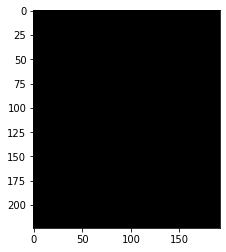

Our output:


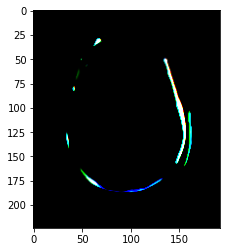


----- Image: 17 -----
Input:


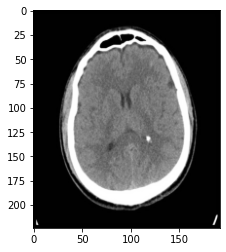

True output:


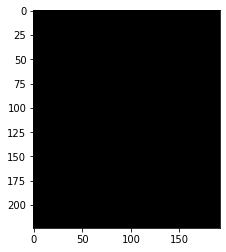

Our output:


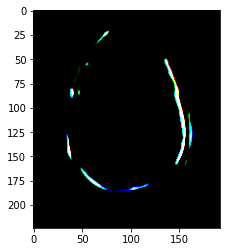


----- Image: 18 -----
Input:


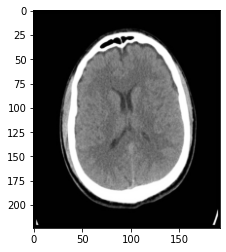

True output:


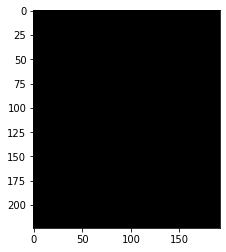

Our output:


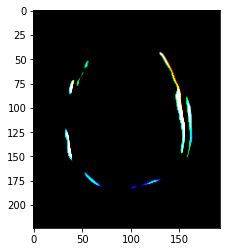

In [ ]:
N = 1
pos = [random.randint(0, len(x_test)-1) for _ in range(N)]


for i_pat in pos:
  for i_img in range(len(x_test[i_pat])):
    print("\n----- Image: %d -----" %i_img)
    
    outputx = x_test[i_pat][i_img]
    outx = outputx.cpu().data.numpy()
    outx = np.transpose(outx, (0,2,3,1))[:,:,:,1:]
    outx = np.reshape(outx, (outx.shape[1], outx.shape[2], outx.shape[3]))
    print("Input:")
    plt.imshow(outx)
    plt.show()

    outy = y_test[i_pat][i_img].cpu()
    outy = np.transpose(outy, (0,2,3,1))[:,:,:,1:]
    outy = np.reshape(outy, (outy.shape[1], outy.shape[2], outy.shape[3]))
    img_outy = outy
    print("True output:")
    plt.imshow(img_outy)
    plt.show()
    
    outx = net(outputx)
    outx = outx.cpu().data.numpy()
    outx = np.transpose(outx, (0,2,3,1))[:,:,:,1:]
    outx = np.reshape(outx, (outx.shape[1], outx.shape[2], outx.shape[3]))
    img_outx = outx
    print("Our output:")
    plt.imshow(img_outx)
    plt.show()
